# LeNet-5-Quantized

In this notebook, i want to demonstrate how i built LeNet-5 in PyTorch and Quantize it for visualization.


> Network details in this [Blog post ](https://engmrk.com/lenet-5-a-classic-cnn-architecture/) and architecture view can be found below.


![alt text](https://miro.medium.com/max/2625/1*1TI1aGBZ4dybR6__DI9dzA.png)


# Requirments


*   PyTorch (torch)
*   torchvision
*   numpy
*   pillow (PIL)



In [0]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets
from PIL import Image


# MNIST Dataset

We will download the dataset with `torchvision` and add to it some transforms like padding so the size of the input images become 32x32.

We then split the data to `train_data` and `test_data` randomly.

We make another split in the training data for validation purposes using `SubsetRandomSampler`.



In [2]:
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20
#  validation sample
valid_sample = 0.2

transform = [transforms.Pad(2), transforms.ToTensor()]

# choose the training and test datasets
train_data = datasets.MNIST(root='data',
                            train=True,
                            download=True,
                            transform=transforms.Compose(transform))
test_data = datasets.MNIST(root='data',
                           train=False,
                           download=True,
                           transform=transforms.Compose(transform))

# Creating validation sampler
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(valid_sample * num_train)
train_idx, valid_idx = indices[split:], indices[:split]

# define sampler for batches
trainSampler = SubsetRandomSampler(train_idx)
validationSampler = SubsetRandomSampler(valid_idx)

# prepare data loaders
train_loader = DataLoader(train_data,
                          batch_size=batch_size,
                          sampler=trainSampler,
                          num_workers=num_workers)
validation_loader = DataLoader(train_data,
                               batch_size=batch_size,
                               sampler=validationSampler,
                               num_workers=num_workers)
test_loader = DataLoader(test_data,
                         batch_size=batch_size,
                         num_workers=num_workers)


  0%|          | 0/9912422 [00:00<?, ?it/s]

9920512it [00:00, 20876899.08it/s]                            


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz


32768it [00:00, 321459.29it/s]                           
0it [00:00, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz


1654784it [00:00, 5213133.69it/s]                           
8192it [00:00, 129855.40it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


# LeNet-5 Network

We inherited form `nn.Module` to construct the LeNet-5 architecture in two steps


1.   initialization of layers in `__init__`
2.   connecting layers to build the pipeline of the network in `forward`



In [3]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # 32 x 32 x 1
        self.conv1 = nn.Conv2d(1, 6, (5, 5), padding=0, stride=1)
        # 28 x 28 x 6
        self.pool1 = nn.AvgPool2d((2, 2), stride=2)
        # 14 x 14 x 6
        self.conv2 = nn.Conv2d(6, 16, (5, 5), padding=0, stride=1)
        # 10 x 10 x 16
        self.pool2 = nn.AvgPool2d((2, 2), stride=2)
        # 5 x 5 x 16
        self.conv3 = nn.Conv2d(16, 120, (5, 5), padding=0, stride=1)
        # 1 x 1 x 120
        self.fc1 = nn.Linear(120, 84)
        self.fc2 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = F.relu(self.conv3(x))
        # Choose either view or flatten (as you like)
        x = x.view(x.size(0), -1)
        # x = torch.flatten(x, start_dim=1)
        x = F.relu(self.fc1(x))
        x = torch.softmax(self.fc2(x), dim=-1)
        return x
      
model = LeNet()
print(model)

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool1): AvgPool2d(kernel_size=(2, 2), stride=2, padding=0)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): AvgPool2d(kernel_size=(2, 2), stride=2, padding=0)
  (conv3): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=120, out_features=84, bias=True)
  (fc2): Linear(in_features=84, out_features=10, bias=True)
)


# Configurations

Here, we configure the loss function to be `CrossEntropyLoss` and the optimizer to be Stochastic Gradient Descent (`SGD`).

In [0]:
# specify loss function
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

# Number of epochs
n_epochs = 30

# classes of MNIST
classes = list(range(10))

# Training & Validation

We first check if a GPU is available so i can transfer the learning to it then,  we put the model in training mode and after every epoch we put the model to `eval` mode so we check the validataion loss is getting better or not to save it in `model.pt`.

In [9]:


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Training Device: {}".format(device))

model.to(device)

valid_loss_min = np.Inf

for epoch in range(n_epochs):

    # monitor training loss
    train_loss = 0.0
    valid_loss = 0.0

    ###################
    # train the model #
    ###################
    model.train()  # prep model for training
    for data, target in train_loader:
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data.to(device))
        # calculate the loss
        loss = criterion(output, target.to(device))
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item() * data.size(0)

    model.eval()
    for data, target in validation_loader:
        output = model(data.to(device))
        loss = criterion(output, target.to(device))
        valid_loss += loss.item() * data.size(0)

    # print training statistics
    # calculate average loss over an epoch
    train_loss = train_loss / len(train_loader.sampler)
    valid_loss = valid_loss / len(validation_loader.sampler)

    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.
          format(epoch + 1, train_loss, valid_loss))
    if valid_loss <= valid_loss_min:
        print(
            'Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'
            .format(valid_loss_min, valid_loss))
        torch.save(model.state_dict(), 'model.pt')
        valid_loss_min = valid_loss


Training Device: cuda:0
Epoch: 1 	Training Loss: 1.674509 	Validation Loss: 1.675145
Validation loss decreased (inf --> 1.675145).  Saving model ...
Epoch: 2 	Training Loss: 1.673003 	Validation Loss: 1.672946
Validation loss decreased (1.675145 --> 1.672946).  Saving model ...
Epoch: 3 	Training Loss: 1.671563 	Validation Loss: 1.675842
Epoch: 4 	Training Loss: 1.645988 	Validation Loss: 1.606506
Validation loss decreased (1.672946 --> 1.606506).  Saving model ...
Epoch: 5 	Training Loss: 1.600649 	Validation Loss: 1.597492
Validation loss decreased (1.606506 --> 1.597492).  Saving model ...
Epoch: 6 	Training Loss: 1.572462 	Validation Loss: 1.519606
Validation loss decreased (1.597492 --> 1.519606).  Saving model ...
Epoch: 7 	Training Loss: 1.513188 	Validation Loss: 1.512397
Validation loss decreased (1.519606 --> 1.512397).  Saving model ...
Epoch: 8 	Training Loss: 1.506405 	Validation Loss: 1.509676
Validation loss decreased (1.512397 --> 1.509676).  Saving model ...
Epoch: 9 	

# Testing

Going through the testing dataset to get the accuracy of the model.

In [10]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()  # prep model for *evaluation*

# Disabling the gradient calculations for faster inference
with torch.no_grad():

  for data, target in test_loader:
      # forward pass: compute predicted outputs by passing inputs to the model
      output = model(data.to(device))
      # calculate the loss
      loss = criterion(output, target.to(device))
      # update test loss
      test_loss += loss.item() * data.size(0)
      # convert output probabilities to predicted class
      _, pred = torch.max(output, 1)
      # compare predictions to true label
      correct = np.squeeze(pred.eq(target.to(device).data.view_as(pred)))
      # calculate test accuracy for each object class
      for i in range(batch_size):
          label = target.data[i]
          class_correct[label] += correct[i].item()
          class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss / len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' %
              (str(i), 100 * class_correct[i] / class_total[i],
               np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' %
              (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' %
      (100. * np.sum(class_correct) / np.sum(class_total),
       np.sum(class_correct), np.sum(class_total)))


Test Loss: 1.491654

Test Accuracy of     0: 98% (965/980)
Test Accuracy of     1: 99% (1127/1135)
Test Accuracy of     2: 97% (1002/1032)
Test Accuracy of     3: 90% (911/1010)
Test Accuracy of     4: 98% (971/982)
Test Accuracy of     5: 97% (872/892)
Test Accuracy of     6: 98% (940/958)
Test Accuracy of     7: 96% (992/1028)
Test Accuracy of     8: 97% (951/974)
Test Accuracy of     9: 96% (974/1009)

Test Accuracy (Overall): 97% (9705/10000)


# Quantization

We deliver a visual representation to the feature maps generated from the learnt weights.

In [14]:

def quantize_arr(arr):
    ''' Quantization based on linear rescaling over min/max range.'''
    min_val, max_val = np.min(arr), np.max(arr)

    if max_val - min_val > 0:
        quantized = np.round(255 * (arr - min_val) / (max_val - min_val))
    else:
        quantized = np.zeros(arr.shape)

    quantized = quantized.astype(np.uint8)
    min_val = min_val.astype(np.float32)
    max_val = max_val.astype(np.float32)

    return quantized, min_val, max_val

example = np.random.randn(5, 5)
print(example)
quant, min_val, max_val = quantize_arr(example)
print("\n{}, Min_Val: {}, Max_Val: {}".format(quant, min_val, max_val))  
    


[[-0.03673913 -0.65374919  0.20401014 -1.61663229 -0.31673855]
 [-0.19385379  0.87996721  0.02324901 -1.61525894 -0.06375492]
 [-0.69819421 -0.8324488   1.32403853 -0.80004356 -1.48020873]
 [-0.10243286 -0.148247   -1.07280287 -1.25149697  0.05074921]
 [ 1.30456389  0.70661624  0.80265717  0.24250077  0.9044146 ]]

[[137  83 158   0 113]
 [123 216 142   0 135]
 [ 80  68 255  71  12]
 [131 127  47  32 145]
 [253 201 210 161 219]], Min_Val: -1.616632342338562, Max_Val: 1.3240385055541992


# Network Analysis
We will go through every layer and print its weights (if any) and the feature maps (outputs).

torch.Size([6, 1, 5, 5])
torch.Size([6])
torch.Size([16, 6, 5, 5])
torch.Size([16])
torch.Size([120, 16, 5, 5])
torch.Size([120])
torch.Size([84, 120])
torch.Size([84])
torch.Size([10, 84])
torch.Size([10])


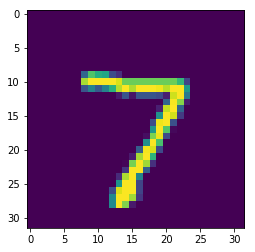

In [66]:
import matplotlib.pyplot as plt
%matplotlib inline

# Moving the model back to the CPU
model.to("cpu")

# parameters of the trained network
param = list(model.parameters())
for paramater in model.parameters():
  print(paramater.shape)
  
  
# Input image for analysis
input_img = next(iter(test_loader))[0][0].squeeze(0)
plt.imshow(input_img)

# Modifying the input image for analysis
input_img = input_img.unsqueeze(0).unsqueeze(0)

## Conv1 Feature Maps

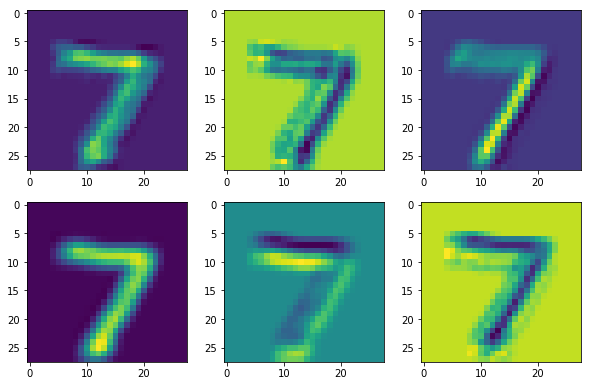

In [41]:

plt.figure(figsize=(10, 10))
row = 2
columns = 3
for i in range(6):
    output, min_val, max_val = quantize_arr(
        model.conv1.forward(input_img)[0][i].detach().numpy())
    plt.subplot(6 / columns + 1, columns, i + 1)
    plt.imshow(output)

## Conv1 Weights

In [67]:
for i in range(6):
  print("{}, Bias: {}\n".format(param[0][i].data, param[1][i]))

tensor([[[-0.1392, -0.0013, -0.0764, -0.0440,  0.2024],
         [ 0.0741,  0.2391, -0.0454,  0.3111,  0.1284],
         [ 0.2625,  0.1316,  0.2938,  0.3271,  0.0010],
         [ 0.2872,  0.1272,  0.1625,  0.1558,  0.1099],
         [-0.1739, -0.0682, -0.0639,  0.1169,  0.2435]]]), Bias: 0.0021541251335293055

tensor([[[-0.1500, -0.0917, -0.1312,  0.0719, -0.0843],
         [-0.0673, -0.1396, -0.0120,  0.0688, -0.1700],
         [-0.1610, -0.1396,  0.1279,  0.0887,  0.1595],
         [-0.0292, -0.1022, -0.1120, -0.1964, -0.1954],
         [-0.0489, -0.0901,  0.1371,  0.0966, -0.1286]]]), Bias: 0.2884324789047241

tensor([[[-0.0940,  0.1093, -0.1816,  0.0386,  0.2490],
         [ 0.0999, -0.1599, -0.0131,  0.3524,  0.1301],
         [-0.1493, -0.1176,  0.2900,  0.3181,  0.2579],
         [-0.0556,  0.0427,  0.1739,  0.1776,  0.0317],
         [-0.0651,  0.2477,  0.2895,  0.1676, -0.0374]]]), Bias: 0.27740278840065

tensor([[[ 0.1140,  0.4061,  0.6366,  0.3694,  0.4018],
         [ 0.877

## Pool1 Feature Maps

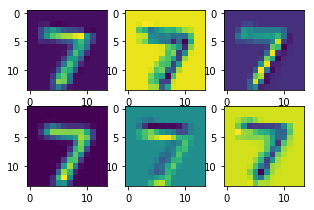

In [42]:
param = list(model.parameters())
plt.figure(figsize=(5, 5))
row = 2
columns = 3
for i in range(6):
    output, min_val, max_val = quantize_arr(
        model.pool1.forward(
            model.conv1.forward(input_img))[0][i].detach().numpy())
    plt.subplot(6 / columns + 1, columns, i + 1)
    plt.imshow(output)


## Conv2 Feature Maps

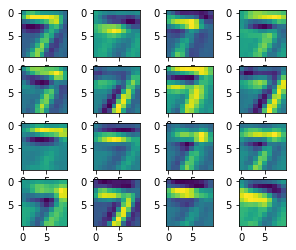

In [43]:
plt.figure(figsize=(5, 5))
row = 4
columns = 4
for i in range(16):
    output, min_val, max_val = quantize_arr(
        model.conv2.forward(
            model.pool1.forward(
                model.conv1.forward(input_img)))[0][i].detach().numpy())
    plt.subplot(16 / columns + 1, columns, i + 1)
    plt.imshow(output)


## Conv2 Weights

In [68]:
for i in range(16):
  print("{}, Bias: {}\n".format(param[2][i].data, param[3][i]))

tensor([[[ 5.7778e-02, -4.5251e-02, -6.9595e-03,  5.3545e-02, -6.0608e-02],
         [-5.0706e-02, -6.0102e-02, -1.1109e-02, -7.7673e-02, -8.4028e-02],
         [-3.4335e-02, -2.6037e-04,  4.2865e-02, -1.6815e-02,  4.4235e-02],
         [ 2.9101e-03,  5.7255e-02,  1.7985e-02,  1.1638e-01,  9.4634e-02],
         [ 2.1092e-02,  5.0036e-02, -6.0927e-02, -5.3108e-02,  5.9632e-02]],

        [[-4.4006e-02,  4.3586e-02, -7.5735e-02,  8.1297e-02,  1.4282e-02],
         [-4.3956e-02,  2.9111e-02, -1.5452e-03, -1.3034e-02, -5.5086e-02],
         [ 6.6408e-02, -3.8516e-02, -2.3768e-02, -2.9432e-02,  7.7599e-02],
         [-4.9443e-02, -6.8727e-02, -9.6019e-02, -7.0200e-02,  4.2996e-02],
         [ 1.5531e-02, -5.0869e-02,  1.6882e-02, -7.1572e-02,  3.5144e-02]],

        [[ 2.9490e-02,  4.5502e-03,  5.9413e-02, -3.5862e-02, -4.7095e-03],
         [-3.8177e-02, -6.9533e-02, -7.2539e-02,  3.9054e-02, -2.2786e-02],
         [ 5.6199e-02, -7.0299e-02,  9.3756e-02,  1.1087e-01, -7.7151e-02],
        

## Pool2 Feature Maps

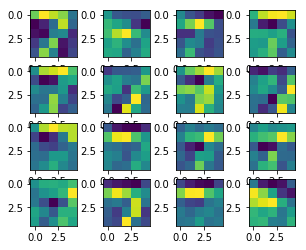

In [44]:
plt.figure(figsize=(5, 5))
row = 4
columns = 4
for i in range(16):
    output, min_val, max_val = quantize_arr(
        model.pool2.forward(
            model.conv2.forward(
                model.pool1.forward(
                    model.conv1.forward(input_img))))[0][i].detach().numpy())
    plt.subplot(16 / columns + 1, columns, i + 1)
    plt.imshow(output)


## Conv3 Outputs

In [56]:
param = list(model.parameters())

for i in range(120):
    output = model.conv3.forward(
        model.pool2.forward(
            model.conv2.forward(
                model.pool1.forward(
                    model.conv1.forward(input_img)))))[0][i].detach().numpy()
    print(output)


[[1.7074544]]
[[-3.9037673]]
[[15.228414]]
[[-4.953825]]
[[-3.7347734]]
[[12.93525]]
[[-10.66523]]
[[-0.7890335]]
[[3.5590482]]
[[-7.3774443]]
[[7.472332]]
[[10.706018]]
[[-0.68280405]]
[[7.6377826]]
[[18.717142]]
[[-1.897709]]
[[8.94978]]
[[-2.823596]]
[[-11.659865]]
[[-3.3671343]]
[[-2.6689727]]
[[2.4460337]]
[[1.0372016]]
[[13.95205]]
[[-5.290026]]
[[0.3682692]]
[[16.485931]]
[[11.5865555]]
[[-3.1836827]]
[[-1.2123958]]
[[-4.8335595]]
[[5.3528113]]
[[-9.069135]]
[[-1.2165319]]
[[-1.6820621]]
[[2.5146565]]
[[17.722094]]
[[-14.214275]]
[[-3.9055388]]
[[11.745384]]
[[-8.200189]]
[[12.8986]]
[[4.2037463]]
[[-2.040829]]
[[-9.050166]]
[[2.4366832]]
[[5.5582933]]
[[-4.8063583]]
[[-2.6098325]]
[[-0.44499868]]
[[3.1810777]]
[[0.6736256]]
[[2.0751703]]
[[-2.6165264]]
[[12.174245]]
[[5.2310805]]
[[-1.21496]]
[[3.9644508]]
[[16.971853]]
[[-10.992371]]
[[-10.789655]]
[[17.047194]]
[[7.6422267]]
[[-12.129458]]
[[-4.003141]]
[[4.385137]]
[[2.4341068]]
[[-1.2280929]]
[[-1.5800779]]
[[-0.5766215]]
[

## Conv3 Weights

In [69]:
for i in range(120):
  print("{}, Bias: {}\n".format(param[4][i].data, param[5][i]))

tensor([[[-0.0329,  0.0264,  0.0235, -0.0558, -0.0590],
         [-0.0218,  0.0106, -0.0520,  0.0306, -0.0450],
         [-0.0056, -0.0164,  0.0492,  0.0266,  0.0093],
         [ 0.0581,  0.0167, -0.0135,  0.0160, -0.0078],
         [-0.0281,  0.0270, -0.0075,  0.0563,  0.0031]],

        [[-0.0367, -0.0417, -0.0060, -0.0339,  0.0058],
         [-0.0163,  0.0210,  0.0084, -0.0335,  0.0065],
         [ 0.0062,  0.0667, -0.0323, -0.0618, -0.0204],
         [ 0.0233,  0.0439, -0.0301,  0.0076, -0.0082],
         [-0.0637, -0.0127, -0.0591, -0.0251, -0.0141]],

        [[ 0.0171, -0.0011,  0.1530,  0.0266,  0.0120],
         [-0.0427, -0.0034, -0.0555, -0.0262, -0.1010],
         [-0.0909,  0.0334,  0.0455,  0.0016, -0.0125],
         [-0.0161,  0.0327,  0.0034, -0.0177, -0.0168],
         [ 0.0330,  0.0665,  0.0498, -0.0044,  0.0469]],

        [[-0.0345,  0.0351, -0.0328, -0.0530, -0.0668],
         [-0.0339, -0.0043, -0.0331, -0.0547, -0.0376],
         [ 0.0039, -0.0459,  0.0396,  0.04

## FC1 Outputs

In [61]:
output = model.fc1.forward(torch.flatten(
    model.conv3.forward(
        model.pool2.forward(
            model.conv2.forward(
                model.pool1.forward(
                    model.conv1.forward(input_img))))), start_dim=1))[0].detach().numpy()
    
print(output)

[ 17.052557    -7.235403    -3.6454833    2.3655057   18.160534
   5.107145     8.610383    -0.6661482    9.172992    -5.848117
   2.7296278   20.40245     -9.28049      9.339558    13.761778
   3.8329084   -4.3581643    5.477696     0.15404093   9.3164625
  13.526836    14.346575    -3.9229755   11.003507     9.0602865
 -13.932806     6.7081037    3.8567045   -4.1894355   -5.949504
  -2.5642912    0.39991692   6.6550145  -13.364462    -3.2279844
   8.049945    -7.722157     9.204617   -20.90334     -6.579002
  -1.9639748   -3.9345443   11.661445     1.3674448   -3.0023632
  -5.89906      6.9045625    4.4984126  -17.89018     11.466324
  17.616102     4.260994     7.4242053    1.0693616   -5.722455
  -2.220241    -1.873821    -1.7719783    2.884684    -1.0229753
 -15.74398      1.6553037   21.571533    -4.4592004   25.772303
   4.587804    12.146106    12.4637165    2.4061997   16.633615
   8.829457     4.1301003   11.76523      6.044397    16.766531
   3.7532063   -0.31100765  -5.9940

## FC1 Weights

In [71]:
for i in range(84):
  print("{}, Bias: {}\n".format(param[6][i].data, param[7][i]))

tensor([-0.0462,  0.0337, -0.0027, -0.0442,  0.0160,  0.0376, -0.0812, -0.0858,
         0.0147, -0.0721,  0.0610,  0.0065, -0.0402,  0.0733, -0.0142, -0.0468,
         0.0746, -0.0634,  0.0004,  0.0694, -0.0013, -0.0774,  0.1980,  0.0619,
        -0.0387,  0.0180, -0.0716, -0.0145,  0.0098, -0.0368,  0.0990,  0.0093,
         0.0217, -0.1558, -0.0416,  0.0002,  0.1141, -0.0091, -0.0387,  0.0397,
        -0.0284, -0.0650,  0.0368, -0.0087, -0.0159,  0.0796, -0.0707, -0.1152,
         0.0546,  0.1128, -0.0649,  0.0574, -0.0287, -0.0402,  0.0513,  0.0604,
        -0.0599, -0.0455, -0.0705, -0.1111,  0.0042,  0.0238, -0.0683, -0.0485,
         0.0098,  0.0948,  0.0643, -0.1031,  0.0070,  0.0693,  0.0772,  0.0251,
         0.0379,  0.0680,  0.0163, -0.0510, -0.0161,  0.0409,  0.0096,  0.0548,
        -0.0417, -0.0967, -0.1298, -0.0688,  0.0148, -0.0370, -0.0037, -0.0112,
         0.0774, -0.0550, -0.0820,  0.0692,  0.0793, -0.0971, -0.0638,  0.0888,
         0.0723, -0.0357, -0.0622,  0.06

## FC2 Outputs

In [64]:
output = model.fc2.forward(model.fc1.forward(torch.flatten(
    model.conv3.forward(
        model.pool2.forward(
            model.conv2.forward(
                model.pool1.forward(
                    model.conv1.forward(input_img))))), start_dim=1)))[0].detach().numpy()
    
print(output)

[ 23.552961 -49.215607 -25.085241  13.662104  -8.299734 -10.060858
 -60.111736  61.66301   27.06371   50.762844]


## FC2 Weights

In [70]:
for i in range(10):
  print("{}, Bias: {}\n".format(param[8][i].data, param[9][i]))

tensor([ 0.2247,  0.0666, -0.0173,  0.0577,  0.2161, -0.0485, -0.0409,  0.0837,
         0.1539,  0.1229, -0.1730,  0.1596, -0.1262, -0.1334, -0.0585,  0.3362,
         0.0138,  0.0371, -0.0085, -0.0119, -0.1588,  0.1204,  0.0696,  0.0406,
        -0.2924, -0.1964,  0.1821,  0.0314,  0.0067, -0.0701, -0.0748, -0.0816,
         0.0532,  0.0252, -0.3614,  0.0334,  0.1708,  0.4232,  0.0031, -0.2386,
         0.0274, -0.0044,  0.1305, -0.0548,  0.0448, -0.0920,  0.0976,  0.2564,
        -0.0944, -0.1692,  0.1769, -0.1532,  0.0522,  0.0225, -0.1104,  0.2434,
        -0.1893,  0.1657,  0.0418,  0.0497, -0.2259, -0.3196, -0.2066, -0.2014,
        -0.1013,  0.0393,  0.1891, -0.0401,  0.0840,  0.1771,  0.0790, -0.2266,
        -0.0446,  0.0565, -0.1395, -0.1965,  0.1558,  0.0129,  0.0649, -0.1003,
         0.0430, -0.1636,  0.0835, -0.0129]), Bias: -0.0030939574353396893

tensor([-0.2229,  0.1105, -0.0011,  0.0225, -0.1771,  0.1404,  0.2437,  0.0211,
        -0.3798, -0.0742,  0.2421, -0.1551, 